Let's look at the SADs at each individual transect

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fsolve
import sad_mrdi as sm
%matplotlib inline

In [3]:
# Import data
df = pd.read_csv('./RawData/Azores_Combined.csv',header=[0,1])

In [4]:
# Get land use types
lu = list(df.columns.levels[0])
lu.remove('Data')
# Reorder to disturbance gradient
lu = [lu[2],lu[0],lu[3],lu[1]]
# Get length to use to loop over etc.
lutypes = len(lu)

# Get list of sites, ignoring first 4 indices which are data information
ls = df.columns[4:]

# Get how many sites for each land use
lu_sites = pd.Series(index=lu,dtype=int)
for l in lu:
    lu_sites[l] = len(df[l].columns)
    print('{}\t{} sites'.format(l,lu_sites[l]))
print()

# Get total s0
s0 = len(df)
print('Number of species: {}'.format(s0))

# Get total n0
n0 = df[lu].sum().sum()
print('Number of individuals: {}'.format(n0))

Native forest	44 sites
Exotic forest	12 sites
Semi-natural pasture	16 sites
Intensive pasture	24 sites

Number of species: 271
Number of individuals: 46250


In [5]:
# Get abundances at each site

# Make arrays
# For s,n,beta
sn_ls = pd.DataFrame(index=ls,columns = {'s0','n0','beta'})
# For abundances
abd_ls = pd.DataFrame(columns=ls)
for l in ls:
    abd_ls[l] = df[l]
    # Get n0 and s0
    stemp = np.count_nonzero(abd_ls[l])
    ntemp = abd_ls[l].sum()
    # Get beta
    btemp = sm.get_beta(stemp,ntemp)
    # Add to dataframe
    sn_ls.loc[l] = {'n0': ntemp, 's0': stemp, 'beta': btemp}

# Rename indexes for abundaces to species code
abd_ls.rename(index=df['Data','MF'],inplace=True)
abd_ls.index.name = 'MF'

# Fix datatype for sn_lu
sn_ls = sn_ls.astype({'s0': 'int64','n0':'int64','beta':'float64'})

sn_ls

beta   n0  s0
Exotic forest        TER-AGUA-T-66  0.051194  114  18
                     TER-MNEG-T-62  0.024182  240  22
                     TER-MNEG-T-63  0.026407  151  15
                     TER-TCHA-T-64  0.014039  362  22
                     TER-ACAR-T111  0.079143   80  17
...                                      ...  ...  ..
Semi-natural pasture TER-NFPG-T-67  0.017547  446  32
                     TER-NFTB-T117  0.013055  310  18
                     TER-NFTB-T-28  0.010077  512  24
                     TER-PB-T165    0.007140  816  29
                     TER-SBAR-T-72  0.006429  762  25

[96 rows x 3 columns]

### Analysing most abundant species
We make the argument in the text that the most abundant species at the pasture sites are small bodied introduced spiders, so we should say which. Here I will show the top 5 most abundant species at the semi-natural and intensive pasture sites, and what percent of the total number of individuals they make up.

In [20]:
# To determine the most abundant at each transect. Ignore this for now.
# Determine most abundant species in semi-natural pasture sites
#idt = []
#for c in abd_ls['Semi-natural pasture'].columns:
#    idt.append(abd_ls['Semi-natural pasture',c].nlargest(3).index.values)
#dtt = pd.DataFrame(idt,columns=[1,2,3])
#for i in dtt.columns:
#    print(dtt[i].value_counts())

# Show most abundant overall
display(abd_ls['Semi-natural pasture'].sum(axis=1).sort_values(ascending=False))
# Now calculate just how abundant for MF 233
snpabd233 = abd_ls['Semi-natural pasture'].loc[233].sum()
snpabd = abd_ls['Semi-natural pasture'].sum().sum()
print(snpabd233)
print(snpabd)
print(snpabd233/snpabd)

MF
233     7638
17       705
10       358
246      239
32       210
        ... 
439        0
1021       0
1169       0
48         0
432        0
Length: 271, dtype: int64

7638
11421
0.6687680588389808


In [21]:
# Now for intensive pasture
# Show most abundant overall
display(abd_ls['Intensive pasture'].sum(axis=1).sort_values(ascending=False))
# Now calculate just how abundant for MF 233
ipabd233 = abd_ls['Intensive pasture'].loc[233].sum()
ipabd = abd_ls['Intensive pasture'].sum().sum()
print(ipabd233)
print(ipabd)
print(ipabd233/ipabd)

MF
233    9062
246    1971
541    1288
540     924
234     725
       ... 
106       0
60        0
54        0
44        0
2         0
Length: 271, dtype: int64

9062
21153
0.4284025906490805


Note that MF 233 is Oedothorax fuscus, a small-bodied grassland spider. 10 is Mythimna unipuncta, a native moth larvae, 17 is Pardosa acorensis, an endemic wolf spider, 246 is Erigone dentipalpis, a small bodied invasive spider, 32, is an introduced beetle, Pterostichus vernalis. 

For the intensive pasture, the top 5 are 233, 246, 541, 540, 234, where 541 is Hirticollis quadriguttatus, a native beetle, 540 is Heteroderes azoricus, an endemic beetle, and 234 is Erigone autumnalis, another small bodied introduced spider.

# Least squares analysis

In [6]:
# Get least squares for each site
# Create storage
sn_ls['mlsq'] = np.zeros(len(sn_ls))#pd.DataFrame(index=ls,columns={'mlsq'})
for l in ls:
    ranks = np.arange(sn_ls['s0'][l])+1
    theory = sm.sad_rank(ranks,sn_ls['s0'][l],sn_ls['beta'][l])
    abd = abd_ls[l]
    emp = np.sort(abd[abd!=0])[::-1]
    # Calculate least squares of log
    if sn_ls['s0'][l] == len(emp):
        if sn_ls['n0'][l] == sum(emp):
            lsq = (np.log(theory)-np.log(emp))**2
            sn_ls.loc[l,'mlsq'] = np.sum(lsq)/len(emp)
        else:
            print("Ruh ro! 1")
    else:
        print("Ruh ro! 2")

In [7]:
# Also plot mean and standard error of mean rather than boxplots. Jonathan pointed out we don't really care about
# the distribution, just the actual mean.
# Note that .std in pandas already has ddof=1, which is correct here since we estimate the mean
# To get the standard error of the mean, we have to divide by sqrt(n)
mean = sn_ls['mlsq'].mean(level=0)
display(mean)
se = sn_ls['mlsq'].std(level=0)
for l in lu:
    se.loc[l] /= np.sqrt(lu_sites[l])
display(se)

Exotic forest           0.300077
Native forest           0.146661
Intensive pasture       0.346007
Semi-natural pasture    0.780059
Name: mlsq, dtype: float64

Exotic forest           0.096396
Native forest           0.017344
Intensive pasture       0.062976
Semi-natural pasture    0.119846
Name: mlsq, dtype: float64

In [7]:
# save the means to file
mlsq_data = pd.DataFrame([mean,se,lu_sites],index=['Mean','Standard error','N'])
display(mlsq_data)
mlsq_data.to_csv('ProcessedData/sad_mlsq.csv')

,Exotic forest,Native forest,Intensive pasture,Semi-natural pasture
Mean,0.300077,0.146661,0.346007,0.780059
Standard error,0.096396,0.017344,0.062976,0.119846
N,12.000000,44.000000,24.000000,16.000000


# Plotting

In [8]:
# With proper colour scheme and better column numbers for native forest
# Make color dictionary
cdic = {lu[0]:'tab:green',lu[1]:'tab:blue',lu[2]:'tab:orange',lu[3]:'tab:red'}
for l in lu:
    nsites = len(df[l].columns)
    # For native forest we want a different array
    if l == 'Native forest':
        # Need to add an extra row
        fig,axs = plt.subplots(int(nsites/6)+1,6,figsize=(10,13),
                               sharex=True,sharey=True,constrained_layout=True)
    else:
        # Make 4 columns and appropriate number of rows
        fig,axs = plt.subplots(int(nsites/4),4,figsize=(8,nsites/2),
                               sharex=True,sharey=True,constrained_layout=True)
    fig.suptitle(l)
    for s, ax in zip(df[l].columns, fig.axes):
        ax.set_title(s,y=0.85)
        # Plot theoretical SAD
        ranks = np.arange(sn_ls.loc[(l,s),'s0'])+1
        ax.semilogy(ranks,sm.sad_rank(ranks,sn_ls.loc[(l,s),'s0'],sn_ls.loc[(l,s),'beta']),c='tab:gray',label='METE')
        # Plot empirical SAD
        abd = np.sort(abd_ls[(l,s)].values)[::-1]
        ax.semilogy(ranks,abd[abd != 0],'o',c=cdic[l],label='Obs.')
        ax.minorticks_on()
    # Now place legend and remove extra plots for Native forest
    if l=='Native forest':
        axs[0,5].legend(loc='upper right', bbox_to_anchor=(1, 0.9))
        for i in np.arange(4,dtype=int):
            axs[7,i+2].axis('off')
        # Turn on xlabels just here
        for ax in axs[6,2:]:
            ax.xaxis.set_tick_params(labelbottom=True)
    else:
        axs[0,3].legend(loc='upper right', bbox_to_anchor=(1, 0.9))
    # Make common x and y axes
    fig.text(0.5, -0.01, 'Rank', ha='center')
    fig.text(-0.01, 0.5, 'Abundance', va='center', rotation='vertical')
    fig.savefig('Figures/SI/sad_{}.pdf'.format(l),bbox_inches='tight')
    fig.clear()

/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 720x936 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x864 with 0 Axes>

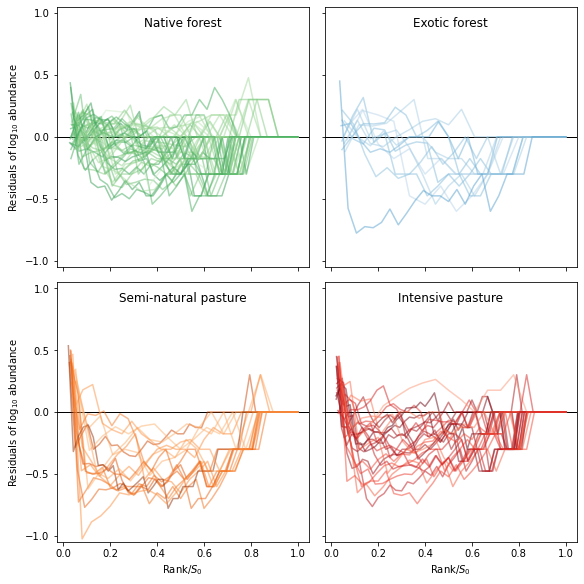

In [11]:
# Plot the residuals all on one plot
fig,axs = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,constrained_layout=True)
# Make color dictionary
cdic = {lu[0]:'Greens',lu[1]:'Blues',lu[2]:'Oranges',lu[3]:'Reds'}

# Get max s0 for color
s0max = max(sn_ls['s0'])
for l, ax in zip(lu,fig.axes):
    # Set title to index
    ax.set_title(l,y=0.9)
    # Set up xline
    ax.axhline(0,c='k',zorder=0,lw=1)
    # Now loop over every site
    for s in df[l].columns:
        # Get temp s0 and ranks
        s0temp = sn_ls.loc[(l,s),'s0']
        ranks = np.arange(s0temp)+1
        # Get temp abundance
        abd = np.sort(abd_ls[(l,s)].values)[::-1]
        # Scale ranks to better compare across sites
        # Plot residuals as log(observed) - log(predicted)
        # Color according to s0 (ie. number of points) in that transect
        pred = sm.sad_rank(ranks,s0temp,sn_ls.loc[(l,s),'beta'])
        ax.plot(ranks/s0temp,(np.log10(abd[abd != 0])-np.log10(pred)),
                c=plt.get_cmap(cdic[l])(s0temp/s0max),alpha=0.5)
        # Set y limits to be the same each time
        ax.set_ylim(-1.05,1.05)#0.65)
        ax.yaxis.set_ticks(np.arange(-1, 1.1, 0.5))

axs[0,0].set_ylabel(r'Residuals of $\log_{10}$ abundance')
axs[1,0].set_ylabel(r'Residuals of $\log_{10}$ abundance')
axs[1,0].set_xlabel(r'Rank/$S_0$')
axs[1,1].set_xlabel(r'Rank/$S_0$')
# Put colorbar legend, if we want
#fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Greys')),ax=axs[:,1],shrink=0.7)

fig.savefig('Figures/residuals_colored.pdf', bbox_inches='tight')

# Save data for KS test

In [13]:
# Save stuff to csvs to import into R
abd_ls.to_csv('ProcessedData/sad_abd.csv')
sn_ls.to_csv('ProcessedData/sad_data.csv')

In [8]:
sn_ls

beta   n0  s0      mlsq
Exotic forest        TER-AGUA-T-66  0.051194  114  18  0.084586
                     TER-MNEG-T-62  0.024182  240  22  0.307291
                     TER-MNEG-T-63  0.026407  151  15  0.546320
                     TER-TCHA-T-64  0.014039  362  22  0.199933
                     TER-ACAR-T111  0.079143   80  17  0.158746
...                                      ...  ...  ..       ...
Semi-natural pasture TER-NFPG-T-67  0.017547  446  32  0.686953
                     TER-NFTB-T117  0.013055  310  18  0.171917
                     TER-NFTB-T-28  0.010077  512  24  0.265792
                     TER-PB-T165    0.007140  816  29  0.642966
                     TER-SBAR-T-72  0.006429  762  25  1.722125

[96 rows x 4 columns]